rhoA slope=10.0000, center=0.1000, avg speed=6.1708
rhoA slope=10.0000, center=0.1292, avg speed=5.6819
rhoA slope=10.0000, center=0.1668, avg speed=5.6863
rhoA slope=10.0000, center=0.2154, avg speed=6.6095
rhoA slope=10.0000, center=0.2783, avg speed=7.0295
rhoA slope=10.0000, center=0.3594, avg speed=8.7466
rhoA slope=10.0000, center=0.4642, avg speed=8.0147
rhoA slope=10.0000, center=0.5995, avg speed=8.5517
rhoA slope=10.0000, center=0.7743, avg speed=7.6961
rhoA slope=10.0000, center=1.0000, avg speed=9.6968
rhoA slope=12.9155, center=0.1000, avg speed=5.8289
rhoA slope=12.9155, center=0.1292, avg speed=5.9330
rhoA slope=12.9155, center=0.1668, avg speed=5.8262
rhoA slope=12.9155, center=0.2154, avg speed=6.8920
rhoA slope=12.9155, center=0.2783, avg speed=6.7826
rhoA slope=12.9155, center=0.3594, avg speed=8.0931
rhoA slope=12.9155, center=0.4642, avg speed=10.1913
rhoA slope=12.9155, center=0.5995, avg speed=8.1936
rhoA slope=12.9155, center=0.7743, avg speed=7.9279
rhoA slope=

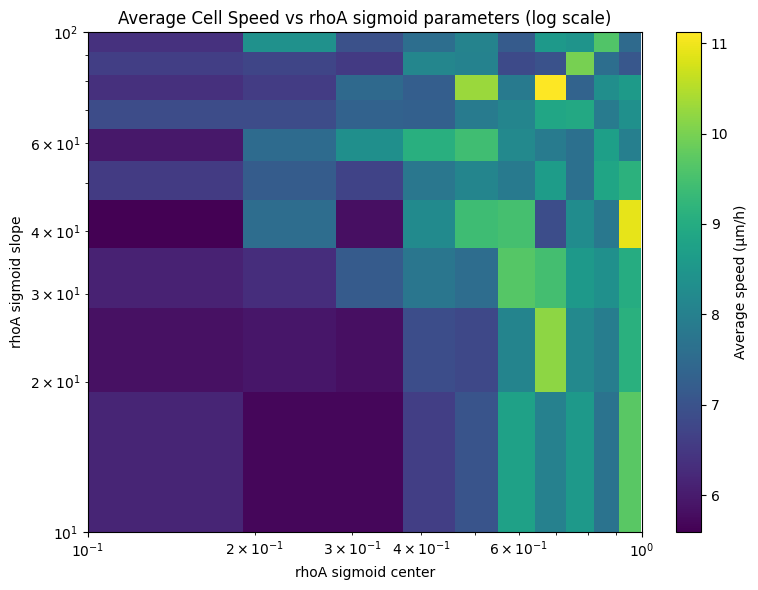

Saved results to speed_rhoA_params_log.csv
deformation base=0.0100, amplitude=0.1000, avg speed=9.7674
deformation base=0.0100, amplitude=0.1668, avg speed=8.9150
deformation base=0.0100, amplitude=0.2783, avg speed=8.3077
deformation base=0.0100, amplitude=0.4642, avg speed=9.8013
deformation base=0.0100, amplitude=0.7743, avg speed=8.6591
deformation base=0.0100, amplitude=1.2915, avg speed=7.0056
deformation base=0.0100, amplitude=2.1544, avg speed=6.3591
deformation base=0.0100, amplitude=3.5938, avg speed=5.6686
deformation base=0.0100, amplitude=5.9948, avg speed=6.7686
deformation base=0.0100, amplitude=10.0000, avg speed=4.1113
deformation base=0.0167, amplitude=0.1000, avg speed=9.2144
deformation base=0.0167, amplitude=0.1668, avg speed=9.5437
deformation base=0.0167, amplitude=0.2783, avg speed=9.3549
deformation base=0.0167, amplitude=0.4642, avg speed=8.1601
deformation base=0.0167, amplitude=0.7743, avg speed=6.2693
deformation base=0.0167, amplitude=1.2915, avg speed=7.8

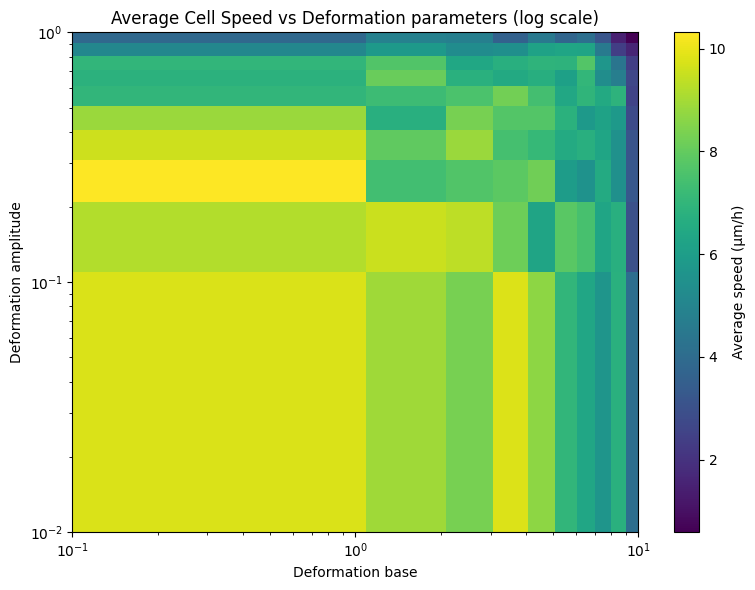

Saved results to speed_deformation_params_log.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
import csv

# ---------- 参数配置 ----------
PARAMS = {
    'A': 100,
    'T': 100,
    'lamda': 0.008,
    'a_spring_curv': 1000.0,
    'k0': 0.1,
    'F_protru': 100.0,
    'L0': 20.0,
    'dt': 0.01,
    'n_steps': 5000,
    'noise_scale_factor': 1 / 150,
    'turn_threshold': 0.2,
    'turn_base_prob': 0.1,
    'turn_freeze_steps': 50,
    'confidence_level': 0.95,
}

# ---------- 生物力学模块 ----------
class MolecularMechanism:
    def __init__(self, max_curvature=0.002,
                 rhoA_slope=8.0, rhoA_center=0.3,
                 deformation_base=0.2, deformation_amplitude=0.8):
        self.max_curvature = max_curvature
        self.rhoA_slope = rhoA_slope
        self.rhoA_center = rhoA_center
        self.deformation_base = deformation_base
        self.deformation_amplitude = deformation_amplitude

    def rac1(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 1.0 / (1 + np.exp(8 * (norm_k - 0.4)))

    def rhoA(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 0.3 + 0.7 / (1 + np.exp(-self.rhoA_slope * (norm_k - self.rhoA_center)))

    def adhesion(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 1.0 - 0.5 * (norm_k ** 2)

    def deformation(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return self.deformation_base + self.deformation_amplitude * norm_k / (1 + norm_k)

    def velocity_modifier(self, rac1, rhoA, adhesion, deformation):
        vmod = 0.7 * rac1 + 0.1 * adhesion - 0.6 * rhoA - 0.2 * deformation
        return np.clip(vmod, 0.2, 1.8)

    def state(self, curvature):
        r = self.rac1(curvature)
        rh = self.rhoA(curvature)
        ad = self.adhesion(curvature)
        de = self.deformation(curvature)
        vm = self.velocity_modifier(r, rh, ad, de)
        return {'rac1': r, 'rhoA': rh, 'adhesion': ad, 'deformation': de, 'velocity_modifier': vm}

# ---------- 细胞迁移模型 ----------
class CellMigrationModel:
    def __init__(self, A, T, lamda=0.01,
                 a_spring_curv=1000.0, F_protru=120.0,
                 L0=10.0, dt=0.001, n_steps=2000,
                 noise_amp=None,
                 mol=None, k0=0.1):
        self.A = A
        self.T = T
        self.lamda = lamda
        self.a_spring_curv = a_spring_curv
        self.F_protru = F_protru
        self.L0 = L0
        self.dt = dt
        self.n_steps = n_steps
        self.noise_amp = noise_amp if noise_amp is not None else T * PARAMS['noise_scale_factor']
        self.mol = mol if mol is not None else MolecularMechanism()
        self.k0 = k0

        self.xn = np.zeros(n_steps)
        self.xp = np.zeros(n_steps)

        self.xn[0] = np.random.uniform(0, T)
        self.xp[0] = self.xn[0] + self.L0

        self.curvature_nuc_list = np.zeros(n_steps)
        self.curvature_prot_list = np.zeros(n_steps)
        self.signals_nuc_list = [None] * n_steps
        self.signals_prot_list = [None] * n_steps
        self.force_nuc_list = np.zeros(n_steps)
        self.force_prot_list = np.zeros(n_steps)

        self.prot_direction = 1
        self.turning = False
        self.turn_freeze_steps = PARAMS['turn_freeze_steps']
        self.turn_freeze_counter = 0
        self.turn_threshold = PARAMS['turn_threshold']
        self.turn_base_prob = PARAMS['turn_base_prob']

    def curvature(self, x):
        h = 1e-6
        y1 = self.A * np.sin(2 * np.pi * (x - h) / self.T)
        y2 = self.A * np.sin(2 * np.pi * (x + h) / self.T)
        y0 = self.A * np.sin(2 * np.pi * x / self.T)
        dy = (y2 - y1) / (2 * h)
        dyy = (y2 - 2 * y0 + y1) / (h * h)
        k = dyy / (1 + dy**2)**1.5
        return np.clip(k, -0.005, 0.005)

    def simulate(self, verbose=False):
        noise_std = self.noise_amp * np.sqrt(self.dt)
        k0 = self.k0

        for i in range(1, self.n_steps):
            L = self.xp[i - 1] - self.xn[i - 1]
            k_nuc = self.curvature(self.xn[i - 1])
            k_prot = self.curvature(self.xp[i - 1])

            ms_nuc = self.mol.state(k_nuc)
            ms_prot = self.mol.state(k_prot)

            F_spring_n = k0 * (1 + self.a_spring_curv * abs(k_nuc)) * (L - self.L0)
            F_spring_p = -F_spring_n

            if self.turning:
                self.turn_freeze_counter -= 1
                if self.turn_freeze_counter <= 0:
                    self.turning = False
            else:
                delta_rac_rho = ms_prot['rac1'] - ms_prot['rhoA']
                adhesion_factor = 1.0 - ms_prot['adhesion']
                turn_prob_dynamic = self.turn_base_prob + adhesion_factor * 0.2
                if delta_rac_rho < self.turn_threshold:
                    if np.random.uniform() < turn_prob_dynamic:
                        self.prot_direction *= -1
                        self.turning = True
                        self.turn_freeze_counter = self.turn_freeze_steps
                        if verbose:
                            print(f"Turn triggered at step {i}, delta_rac_rho={delta_rac_rho:.3f}, adhesion={ms_prot['adhesion']:.3f}")

            F_protrusion = self.prot_direction * self.F_protru * (ms_prot['rac1'] * 0.7 + ms_prot['adhesion'] * 0.3)

            lamda_nuc = self.lamda * (1 + ms_nuc['deformation'])

            F_total_n = F_spring_n
            F_total_p = F_spring_p + F_protrusion

            v_n = (F_total_n / lamda_nuc) * ms_nuc['velocity_modifier']
            v_p = (F_total_p / self.lamda) * ms_prot['velocity_modifier']

            noise_n = np.random.normal(0, noise_std)
            noise_p = np.random.normal(0, noise_std)

            self.xn[i] = self.xn[i - 1] + v_n * self.dt + noise_n
            self.xp[i] = self.xp[i - 1] + v_p * self.dt + noise_p

            self.curvature_nuc_list[i] = k_nuc
            self.curvature_prot_list[i] = k_prot
            self.signals_nuc_list[i] = ms_nuc.copy()
            self.signals_prot_list[i] = ms_prot.copy()
            self.force_nuc_list[i] = F_total_n
            self.force_prot_list[i] = F_total_p

    def get_cell_length(self):
        return self.xp[-1] - self.xn[-1]

    def get_velocity(self):
        velocities = np.diff(self.xn) / self.dt
        start_idx = int(len(velocities) * 0.4)
        return np.mean(velocities[start_idx:])

# ---------- 批量采样函数 ----------
def run_speed_test_rhoA(rhoA_slopes, rhoA_centers, n_repeat=50):
    results = np.zeros((len(rhoA_slopes), len(rhoA_centers)))
    for i, slope in enumerate(rhoA_slopes):
        for j, center in enumerate(rhoA_centers):
            speeds = []
            for _ in range(n_repeat):
                mol = MolecularMechanism(
                    rhoA_slope=slope, rhoA_center=center,
                    deformation_base=0.2, deformation_amplitude=0.8)
                model = CellMigrationModel(
                    A=PARAMS['A'], T=PARAMS['T'], lamda=PARAMS['lamda'],
                    a_spring_curv=PARAMS['a_spring_curv'],
                    F_protru=PARAMS['F_protru'], L0=PARAMS['L0'],
                    dt=PARAMS['dt'], n_steps=PARAMS['n_steps'],
                    noise_amp=PARAMS['T'] * PARAMS['noise_scale_factor'],
                    mol=mol, k0=PARAMS['k0'])
                model.simulate()
                speed_val = model.get_velocity()
                speeds.append(np.abs(speed_val))
            results[i, j] = np.mean(speeds)
            print(f"rhoA slope={slope:.4f}, center={center:.4f}, avg speed={results[i,j]:.4f}")
    return results


def run_speed_test_deformation(deform_bases, deform_amplitudes, n_repeat=20):
    results = np.zeros((len(deform_bases), len(deform_amplitudes)))
    for i, base in enumerate(deform_bases):
        for j, amp in enumerate(deform_amplitudes):
            speeds = []
            for _ in range(n_repeat):
                mol = MolecularMechanism(
                    rhoA_slope=8.0, rhoA_center=0.3,
                    deformation_base=base, deformation_amplitude=amp)
                model = CellMigrationModel(
                    A=PARAMS['A'], T=PARAMS['T'], lamda=PARAMS['lamda'],
                    a_spring_curv=PARAMS['a_spring_curv'],
                    F_protru=PARAMS['F_protru'], L0=PARAMS['L0'],
                    dt=PARAMS['dt'], n_steps=PARAMS['n_steps'],
                    noise_amp=PARAMS['T'] * PARAMS['noise_scale_factor'],
                    mol=mol, k0=PARAMS['k0'])
                model.simulate()
                speed_val = model.get_velocity()
                speeds.append(np.abs(speed_val))
            results[i, j] = np.mean(speeds)
            print(f"deformation base={base:.4f}, amplitude={amp:.4f}, avg speed={results[i,j]:.4f}")
    return results


# ---------- 绘制对数坐标热图 ----------
def plot_heatmap_log(x_vals, y_vals, Z, xlabel, ylabel, title, cmap='viridis'):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(Z, origin='lower', aspect='auto',
                    extent=[y_vals[0], y_vals[-1], x_vals[0], x_vals[-1]],
                    cmap=cmap)
    plt.colorbar(im, label='Average speed (μm/h)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


# ---------- CSV导出 ----------
def save_results_to_csv(filename, x_vals, y_vals, Z, x_label, y_label):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        header = [y_label + "\\" + x_label] + list(y_vals)
        writer.writerow(header)
        for xi, row in zip(x_vals, Z):
            writer.writerow([xi] + list(row))
    print(f"Saved results to {filename}")


# ---------- 主程序 ----------
if __name__ == "__main__":
    # 1. rhoA sigmoid斜率和中心点对速度影响（对数采样）
    rhoA_slopes = np.logspace(1, 2, 10)  # 1到约20
    rhoA_centers = np.logspace(-1, 0, 10)  # 0.1到1
    speed_rhoA = run_speed_test_rhoA(rhoA_slopes, rhoA_centers, n_repeat=50)
    plot_heatmap_log(rhoA_slopes, rhoA_centers, speed_rhoA,
                     xlabel='rhoA sigmoid center',
                     ylabel='rhoA sigmoid slope',
                     title='Average Cell Speed vs rhoA sigmoid parameters (log scale)')
    save_results_to_csv('speed_rhoA_params_log.csv', rhoA_slopes, rhoA_centers, speed_rhoA,
                        x_label='rhoA sigmoid center', y_label='rhoA sigmoid slope')

    # 2. deformation基底和幅度对速度影响（对数采样）
    deform_bases = np.logspace(np.log10(0.01), np.log10(1), 10)
    deform_amps = np.logspace(np.log10(0.1), np.log10(10), 10)
    speed_deform = run_speed_test_deformation(deform_bases, deform_amps, n_repeat=50)
    plot_heatmap_log(deform_bases, deform_amps, speed_deform,
                     xlabel='Deformation base',
                     ylabel='Deformation amplitude',
                     title='Average Cell Speed vs Deformation parameters (log scale)')
    save_results_to_csv('speed_deformation_params_log.csv', deform_bases, deform_amps, speed_deform,
                        x_label='Deformation amplitude', y_label='Deformation base')
